# 1- Perkenalan

- Nama : Didit Eko Setyo Ariandi
- batch : 015 
- dataset : Face Mask 12k images
- objective : 

## Obective
Penelitian ini dilatarbelakangi oleh data gambar dari dataset yang didapat dari kaggle, yang menunjukkan apa seseorang memakai masker atau tidak, karena dimasa pandemi ini masih banyak orang yang tidak mematuhi aturan memakai masker ditempat umum. Untuk merespons hal itu maka peneliti melakukan penelitian dan pembuatan modeling dengan menggunakan teknik CNN dan algoritma sequential dengan bahasa program python beserta librarynnya untuk mengetahui memakai masker atau tidak. Tujuan yang hendak dicapai pada penelitian ini antara lain: (1) Mengetahui dengan jelas apakah seseorang memakai masker atau tidak dan (2) membantu mencegah penyebara pandemi virus yang lagi menyebar diseluruh dunia

# 2- Import Libraries

In [ ]:
# Install Kaggle library
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d ashishjangra27/face-mask-12k-images-dataset

100% 329M/330M [00:04<00:00, 74.3MB/s]
100% 330M/330M [00:04<00:00, 80.9MB/s]


In [ ]:
!unzip -q /content/face-mask-12k-images-dataset.zip -d images

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten, MaxPool2D

from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# 3-  Data Loading

In [ ]:
path = os.listdir('/content/images/Face Mask Dataset')
path

['Test', 'Train', 'Validation']

In [ ]:
main_path= '/content/images/Face Mask Dataset'

In [ ]:
train_dir = os.path.join(main_path, 'Train')
test_dir = os.path.join(main_path, 'Test')
val_dir = os.path.join(main_path, 'Validation')

In [ ]:
print('train set: \n' + '='*50)
WithoutMask= len(os.listdir(os.path.join(train_dir, 'WithoutMask')))
WithMask= len(os.listdir(os.path.join(train_dir, 'WithMask')))
print(f'jumlah tanpa masker= {WithoutMask}')
print(f'jumlah pake masker= {WithMask}')

train set: 
jumlah tanpa masker= 5000
jumlah pake masker= 5000


- pada data train kita mempunyai data berjumlah 10.000 data gambar

In [ ]:
print('test set: \n' + '='*50)
WithoutMask= len(os.listdir(os.path.join(test_dir, 'WithoutMask')))
WithMask= len(os.listdir(os.path.join(test_dir, 'WithMask')))
print(f'jumlah tanpa masker= {WithoutMask}')
print(f'jumlah pake masker= {WithMask}')

test set: 
jumlah tanpa masker= 509
jumlah pake masker= 483


- pada data test kita mempunyai data berjumlah 992 data gambar

In [ ]:
print('val set: \n' + '='*50)
WithoutMask= len(os.listdir(os.path.join(val_dir, 'WithoutMask')))
WithMask= len(os.listdir(os.path.join(val_dir, 'WithMask')))
print(f'jumlah tanpa masker= {WithoutMask}')
print(f'jumlah pake masker= {WithMask}')

val set: 
jumlah tanpa masker= 400
jumlah pake masker= 400


- pada data validation kita mempunyai data berjumlah 800 data gambar

In [ ]:
train_WithoutMask = glob.glob(train_dir+"/WithoutMask/*.png")
train_WithMask = glob.glob(train_dir+"/WithMask/*.png")

test_WithoutMask = glob.glob(test_dir+"/WithoutMask/*.png")
test_WithMask = glob.glob(test_dir+"/WithMask/*.png")

val_WithoutMask = glob.glob(val_dir+"/WithoutMask/*.png")
val_WithMask = glob.glob(val_dir+"/WithMask/*.png")

# 4- Exploratory Data Analysis (EDA)

In [ ]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        ##ambil nama dari file \ ke -1
        # images.append(image.split('\')[-1]) 
        # label.append(image.split('\')[-2])
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_df = create_dataframe(train_WithoutMask + train_WithMask)
train_df = train_df.sample(frac=1, random_state=21).reset_index(drop=True)

test_df = create_dataframe(test_WithoutMask + test_WithMask)
test_df = test_df.sample(frac=1, random_state=21).reset_index(drop=True)

val_df = create_dataframe(val_WithoutMask + val_WithMask)
val_df = val_df.sample(frac=1, random_state=21).reset_index(drop=True)

membuat fungsi dimana `fungsi tersebut nanti akan mempermudah peneliti untuk membuat dataframe`, dikarenakan data adalah berupa gambar, maka peneliti membuat dataframe dengan 2 column dimana column tersebut adalah `images dan label`

In [ ]:
print(train_df.shape)
train_df.head()

(10000, 2)


,images,label
0,/content/images/Face Mask Dataset/Train/Withou...,WithoutMask
1,/content/images/Face Mask Dataset/Train/Withou...,WithoutMask
2,/content/images/Face Mask Dataset/Train/WithMa...,WithMask
3,/content/images/Face Mask Dataset/Train/WithMa...,WithMask
4,/content/images/Face Mask Dataset/Train/WithMa...,WithMask


In [ ]:
print(test_df.shape)
test_df.head()

(992, 2)


,images,label
0,/content/images/Face Mask Dataset/Test/Without...,WithoutMask
1,/content/images/Face Mask Dataset/Test/Without...,WithoutMask
2,/content/images/Face Mask Dataset/Test/Without...,WithoutMask
3,/content/images/Face Mask Dataset/Test/Without...,WithoutMask
4,/content/images/Face Mask Dataset/Test/Without...,WithoutMask


In [ ]:
print(val_df.shape)
val_df.head()

(800, 2)


,images,label
0,/content/images/Face Mask Dataset/Validation/W...,WithoutMask
1,/content/images/Face Mask Dataset/Validation/W...,WithMask
2,/content/images/Face Mask Dataset/Validation/W...,WithMask
3,/content/images/Face Mask Dataset/Validation/W...,WithoutMask
4,/content/images/Face Mask Dataset/Validation/W...,WithoutMask


- setelah menjadi dataframe , colums images menjadi path lokasi image tersebut.

In [ ]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Set2')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

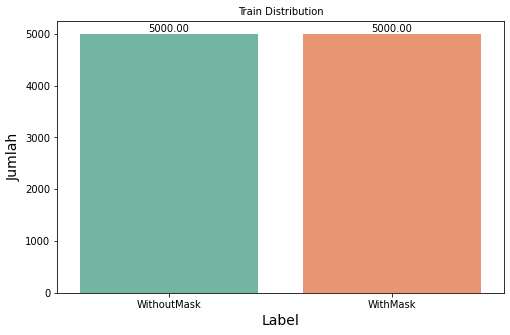

In [ ]:
visualize_data(train_df, 'Train')

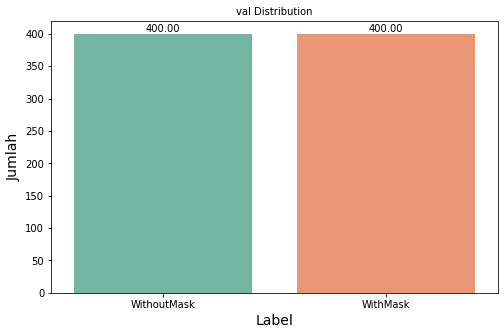

In [ ]:
visualize_data(val_df, 'val')

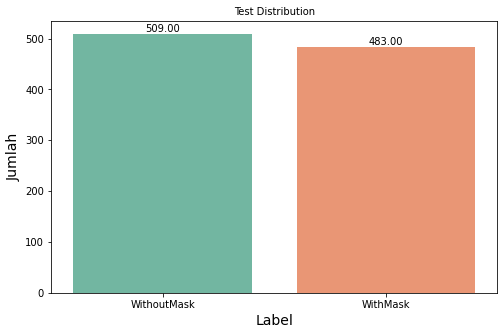

In [ ]:
visualize_data(test_df, 'Test')

- Dilihat dari histogram diatas kita sudah memilki data yang balance

In [ ]:
# Get few samples for both the classes
WithoutMask_samples = (train_df[train_df['label']=="WithoutMask"]['images'].iloc[:5]).tolist()
WithMask_samples = (train_df[train_df['label']=='WithMask']['images'].iloc[:5]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i//5, i%5].set_title(sample.split('/')[-2])
        ax[i//5, i%5].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()


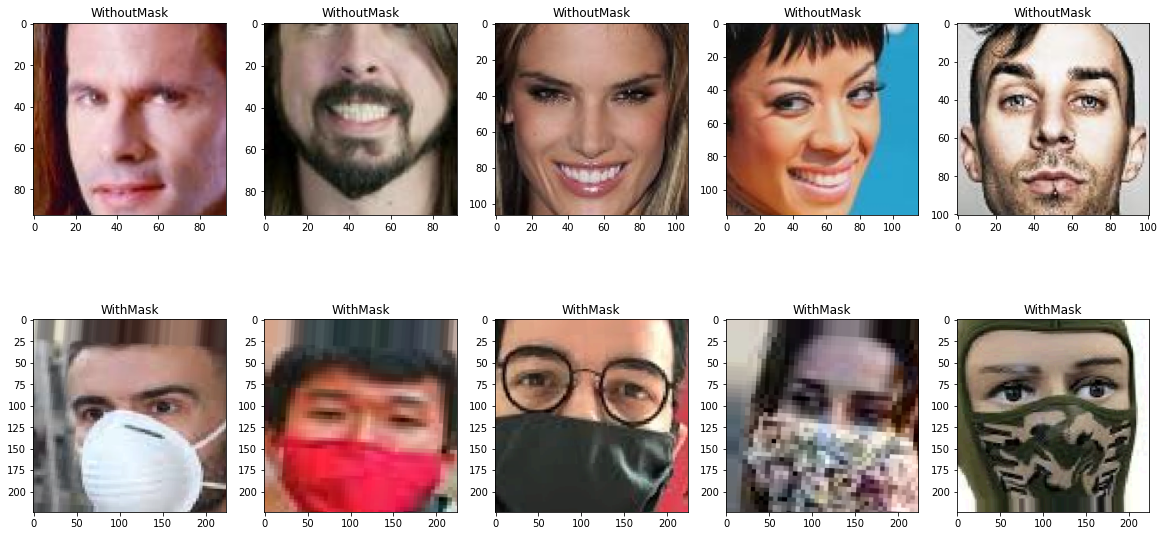

In [ ]:
visualize_samples(WithoutMask_samples + WithMask_samples)

Menampilkan data sample berupa gambar, dan terlihat dataset berbentuk RGB, untuk memakai masker atau tidak

# 5- Data Preprocessing

## Augmentasi Data

In [ ]:
img_height= 220
img_width= 220
SEED = 1
BATCH =64

- membuat ukuran gambar yg kan digunkan dengan height 220 dan width 220

In [ ]:
# create image generator
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=0.1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

vaL_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_dataset = train_datagen.flow_from_directory(directory='/content/images/Face Mask Dataset/Train', 
                                             batch_size=64, 
                                             shuffle=True, 
                                             class_mode='categorical',
                                             target_size=(220, 220))

validation_dataset = vaL_datagen.flow_from_directory(directory='/content/images/Face Mask Dataset/Validation', 
                                                 batch_size=64, 
                                                 shuffle=False, 
                                                 class_mode='categorical',
                                                 target_size=(220, 220))

test_dataset = test_datagen.flow_from_directory(directory='/content/images/Face Mask Dataset/Test', 
                                             batch_size=64, 
                                             shuffle=False, 
                                             class_mode='categorical',
                                             target_size=(220, 220))

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


- membagi dataset menjadi train test val dan mendifinisikan image data generator agar data dapat digunakan

In [ ]:
test_dataset.class_indices

{'WithMask': 0, 'WithoutMask': 1}

In [ ]:
class_names = train_dataset.class_indices
print('Class names - train      : ', class_names)

class_names = validation_dataset.class_indices
print('Class names - validation : ', class_names)

Class names - train      :  {'WithMask': 0, 'WithoutMask': 1}
Class names - validation :  {'WithMask': 0, 'WithoutMask': 1}


terdapat 2 class pada dataset yaitu `'WithMask': 0,
 'WithoutMask': 1,

# 6- Model definition dan Model Training

## Model Baseline

In [ ]:
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience =2 ), 
    ModelCheckpoint('model_best.hdf5', monitor='val_loss', save_best_only=True)
]

- membuat callback dengan nilai 2 dimana jika model mengalami penurunan val_loss sebanyak 2 kali maka saat model training akan langsung stop

In [ ]:
inputs= [img_height,img_width,3]


model = Sequential()
model.add(Conv2D(4,3, activation ='relu', input_shape=inputs))
model.add(MaxPool2D(2))

model.add(Conv2D(8,3, activation ='relu'))
model.add(MaxPool2D(2))

#flattened
model.add(Flatten())
model.add(Dense(8, activation = 'relu'))

model.add(Dense(2, activation = 'softmax'))

- dilihat disini menggunakan 4 filters dan  3 kernel, dengan output layer 2 neuron, dengan ditambahkan aktivasi relu dimana untuk menyalakan neuron ,untuk aktifasi peneliti memilih Softmax dimana softmax untuk clasisifikasi  2 atau multiclass , disini peneliti untuk menerapkan baseline model memakai Softmax. Untuk loss peneliti memakai categorical_crossentropy, categorical_crossentropy adalah fungsi loss default yang digunakan untuk masalah klasifikasi dengan 2 class, , untuk baseline peneliti mencoba memakai optimizer Adam, dan untuk metrics memakai accuracy, dikarenakan ingin membuat model untuk case classification

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 218, 218, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 109, 109, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 107, 107, 8)       296       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 8)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 22472)             0         
                                                                 
 dense (Dense)               (None, 8)                 1

- Terlihat total params untuk baseline model 180210 ribu dengan 2 filter , 2 max pooling, 1 flattern dan 2 hidden layer

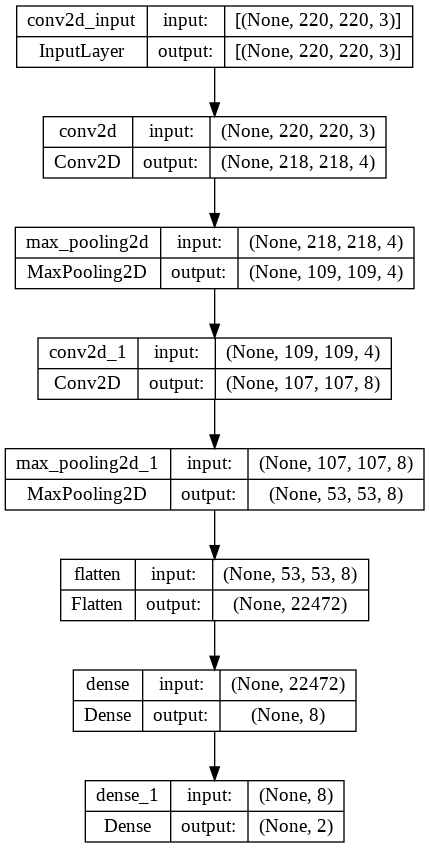

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics= ['accuracy'])

- disini saat compile menggunakan optimezer adam, kemudian loss categorical crossentrophy, metric = ['accuracy']

In [ ]:
history= model.fit(train_dataset, batch_size= BATCH, 
                    epochs= 10, validation_data= validation_dataset,
                   callbacks= callbacks1)

Epoch 1/10
157/157 [==============================] - 117s 667ms/step - loss: 0.4733 - accuracy: 0.8068 - val_loss: 0.1994 - val_accuracy: 0.9425
Epoch 2/10
157/157 [==============================] - 104s 664ms/step - loss: 0.2133 - accuracy: 0.9240 - val_loss: 0.1815 - val_accuracy: 0.9362
Epoch 3/10
157/157 [==============================] - 102s 649ms/step - loss: 0.2037 - accuracy: 0.9248 - val_loss: 0.1666 - val_accuracy: 0.9438
Epoch 4/10
157/157 [==============================] - 104s 661ms/step - loss: 0.1849 - accuracy: 0.9307 - val_loss: 0.1237 - val_accuracy: 0.9563
Epoch 5/10
157/157 [==============================] - 103s 657ms/step - loss: 0.1669 - accuracy: 0.9354 - val_loss: 0.1271 - val_accuracy: 0.9675
Epoch 6/10
157/157 [==============================] - 103s 654ms/step - loss: 0.1504 - accuracy: 0.9435 - val_loss: 0.1353 - val_accuracy: 0.9488


- saat training model menggunakan epoch sebesar 10 artinya model akan mengulang sebnayak 10 kali

In [ ]:
history_df = pd.DataFrame(history.history)
history_df

,loss,accuracy,val_loss,val_accuracy
0,0.473279,0.8068,0.199428,0.94250
1,0.213324,0.9240,0.181489,0.93625
2,0.203693,0.9248,0.166556,0.94375
3,0.184895,0.9307,0.123701,0.95625
4,0.166864,0.9354,0.127113,0.96750
5,0.150362,0.9435,0.135347,0.94875


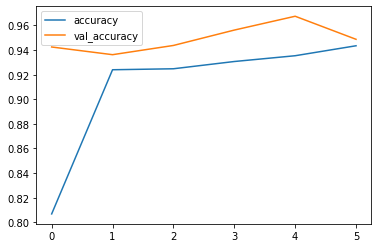

In [ ]:
#Plot between Accuracy and val_accuracy

history_df[['accuracy', 'val_accuracy']].plot()

dari grafik di atas setiap penambahan epoch accurasi meningkat,dan  accurasi val lebih tinggi dari accuracy dan itu sudah menunjukan model bagus

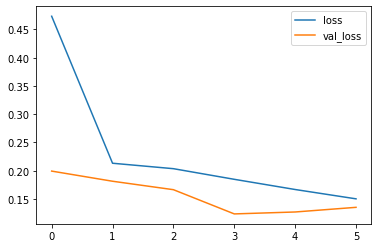

In [ ]:
# Plot between loss and val_loss

history_df[['loss', 'val_loss']].plot()

Dari grafik diatas dapat dilihat bahwa loss dan vall semakin berkurang secara konvergen seiring bertambahnya epoch dan ini sudah menunjukan hasil yang baik

In [ ]:
y_pred = model.predict(test_dataset)


print(classification_report(test_dataset.classes, np.array(y_pred).argmax(axis=1)))

16/16 [==============================] - 2s 122ms/step
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       483
           1       0.98      0.92      0.95       509

    accuracy                           0.95       992
   macro avg       0.95      0.95      0.95       992
weighted avg       0.95      0.95      0.95       992



Untuk target 0


---
<b>Precision</b>:`92% dari 483(hasil support) ,memperediksi orang yang ada dikelas 0 dengan benar`. dan `8 % salah prediksi tentang 0` dan dimasukan ke kelas 1
,`2% kita prediksi 0 padahal bukan,dimana 0 adalah status memakai masker`<br>
<b>Recall</b>: `98% berhasil memprediksi orang yang ada di kelas 0 dengan benar`,` 2% salah prediksi, kita prediksi bukan sebagai 0, `padahal harusnya dia
masuk ke kelas 0, dimana 0 adalah memakai masker

Untuk target 1


---

<b>Precision</b>:`98% dari 509(hasil support) ,memperediksi orang yang ada dikelas 1 dengan benar`. dan `2 % salah prediksi tentang 1 dan dimasukan ke kelas 0`. ,`2% kita prediksi 1 padahal bukan`,dimana 1 adalah tidak memakai masker<br>
<b>Recall</b>: `92% berhasil memprediksi orang yang ada di kelas 1 dengan benar`, `8% salah prediksi, kita prediksi bukan sebagai 1`, padahal harusnya dia masuk ke kelas 1 dimana 1 adalah tidak memakai masker

untuk akurasi kita dapat di angka 98% dimana itu sudah baik skrng dan akan dilakukan model improvement agar mendapat hasil yang lebih baik

Confusion Matrix


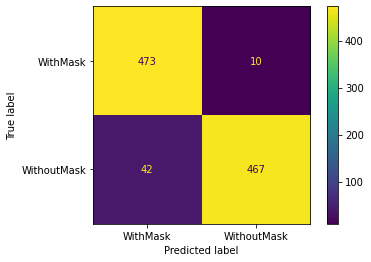

In [ ]:
#confusion matrix for test dataset
print('Confusion Matrix')
confmat = confusion_matrix(test_dataset.classes,np.array(y_pred).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['WithMask','WithoutMask'])
disp.plot()
plt.show()

Dari confesion matrix dapat dilihat :
- With Mask: model memprediksi 473 orang memakai masker dan memprediksi 10 data memakai masker pdahal dia tidak memakai masker
- without mask: model memprediksi 467 tidak memakai masker dan mempredisksi 42 data tidak memakai masker padahal dia memakai masker 

## MODEL IMPROVEMENT

In [ ]:
callbacks2 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 6), 
    ModelCheckpoint('model_best2.hdf5', monitor='val_loss', save_best_only=True)
]

- membuat callback dengan nilai 6 dimana jika model mengalami penurunan val_loss sebanyak 6 kali maka saat model training akan langsung stop

In [ ]:
inputs= [img_height,img_width,3]

model_imp2 = Sequential()
model_imp2.add(Conv2D(32,3, activation ='relu', input_shape=inputs))
model_imp2.add(MaxPool2D(2))

model_imp2.add(Conv2D(64,3, activation ='relu'))
model_imp2.add(MaxPool2D(2))

#flattened
model_imp2.add(Flatten())
model_imp2.add(Dense(32, activation = 'relu', kernel_initializer=tf.keras.initializers.GlorotNormal(seed=40)))
model_imp2.add(Dense(16, activation = 'relu'))
model_imp2.add(Dense(2, activation = 'softmax'))

- dilihat disini menggunakan 32 filters dan  3 kernel, dengan output layer 2 neuron, dengan ditambahkan aktivasi relu dimana untuk menyalakan neuron ,untuk aktifasi peneliti memilih Softmax dimana softmax untuk clasisifikasi  2 atau multiclass , disini peneliti untuk menerapkan baseline model memakai Softmax. Untuk loss  memakai categorical_crossentropy, categorical_crossentropy adalah fungsi loss default yang digunakan untuk masalah klasifikasi dengan 2 class, , untuk baseline peneliti mencoba memakai optimizer Adam, dan untuk metrics memakai accuracy, dikarenakan ingin membuat model untuk case classification

In [ ]:
model_imp2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 109, 109, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 179776)            0         
                                                                 
 dense_2 (Dense)             (None, 32)               

untuk `improvement 5.772.818 juta parameter`, `sebelum improvement sebesar `180210 ribu params`

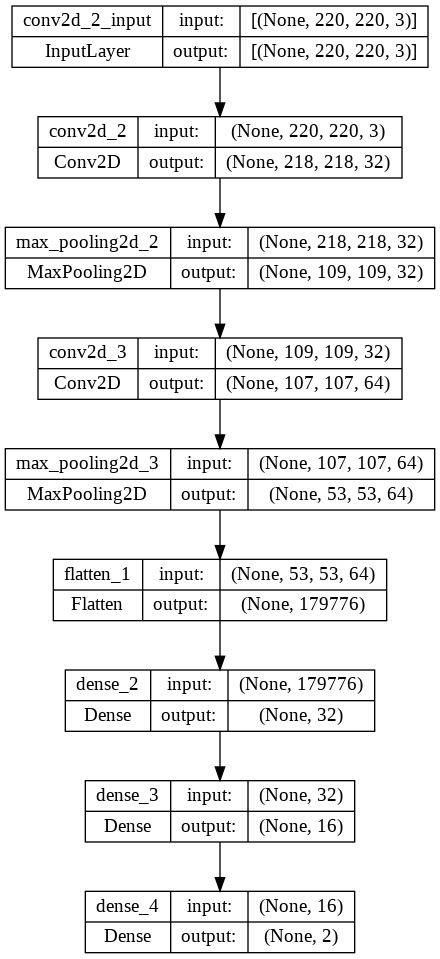

In [ ]:
tf.keras.utils.plot_model(model_imp2, show_shapes=True)

In [ ]:
#model compile
model_imp2.compile(loss="categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics = ['accuracy'])

- disini saat compile menggunakan optimezer adam, kemudian loss categorical_crossentrophy, metric = ['accuracy'] ditambah dengan learning rate 0.001

In [ ]:
his = model_imp2.fit(train_dataset, epochs = 50, validation_data = validation_dataset, callbacks = callbacks2)

Epoch 1/50
157/157 [==============================] - 108s 681ms/step - loss: 0.2805 - accuracy: 0.8840 - val_loss: 0.1463 - val_accuracy: 0.9513
Epoch 2/50
157/157 [==============================] - 105s 672ms/step - loss: 0.1675 - accuracy: 0.9370 - val_loss: 0.1227 - val_accuracy: 0.9550
Epoch 3/50
157/157 [==============================] - 106s 674ms/step - loss: 0.1484 - accuracy: 0.9462 - val_loss: 0.0909 - val_accuracy: 0.9725
Epoch 4/50
157/157 [==============================] - 106s 672ms/step - loss: 0.1445 - accuracy: 0.9478 - val_loss: 0.0974 - val_accuracy: 0.9712
Epoch 5/50
157/157 [==============================] - 106s 674ms/step - loss: 0.1361 - accuracy: 0.9521 - val_loss: 0.0874 - val_accuracy: 0.9663
Epoch 6/50
157/157 [==============================] - 105s 666ms/step - loss: 0.1243 - accuracy: 0.9563 - val_loss: 0.0702 - val_accuracy: 0.9750
Epoch 7/50
157/157 [==============================] - 105s 670ms/step - loss: 0.1270 - accuracy: 0.9538 - val_loss: 0.0769 -

- saat training model menggunakan epoch sebesar 50 artinya model akan mengulang sebnayak 50 kali

#8-Model Evaluation

In [ ]:
history_df2 = pd.DataFrame(his.history)
history_df2

,loss,accuracy,val_loss,val_accuracy
0,0.280536,0.8840,0.146306,0.95125
1,0.167473,0.9370,0.122688,0.95500
2,0.148351,0.9462,0.090944,0.97250
3,0.144497,0.9478,0.097421,0.97125
4,0.136061,0.9521,0.087396,0.96625
5,0.124343,0.9563,0.070176,0.97500
6,0.126985,0.9538,0.076894,0.97125
7,0.100418,0.9646,0.052298,0.98375
8,0.094555,0.9663,0.050143,0.98000
9,0.094800,0.9655,0.041391,0.98625


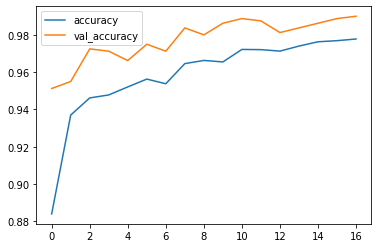

In [ ]:
# Plot between Accuracy and val_accuracy

history_df2[['accuracy', 'val_accuracy']].plot()

dari grafik di atas setiap penambahan epoch accurasi meningkat,dan  accurasi val lebih tinggi dari accuracy dan itu sudah menunjukan model bagus

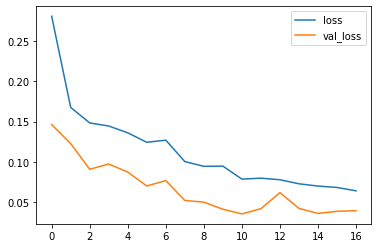

In [ ]:
# Plot between loss and val_loss

history_df2[['loss', 'val_loss']].plot()

Dari grafik diatas dapat dilihat bahwa loss dan vall semakin berkurang secara konvergen seiring bertambahnya epoch dan ini sudah menunjukan hasil yang baik

In [ ]:
y_pred_imp = model_imp2.predict(test_dataset)


print(classification_report(test_dataset.classes, np.array(y_pred_imp).argmax(axis=1)))

16/16 [==============================] - 2s 128ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       483
           1       0.99      0.99      0.99       509

    accuracy                           0.99       992
   macro avg       0.99      0.99      0.99       992
weighted avg       0.99      0.99      0.99       992



Untuk target 0


---
<b>Precision</b>:`99% dari 483(hasil support) ,memperediksi orang yang ada dikelas 0 dengan benar`. dan `1 % salah prediksi tentang 0` dan dimasukan ke kelas 1
,`1% kita prediksi 0 padahal bukan,dimana 0 adalah status memakai masker`<br>
<b>Recall</b>: `99% berhasil memprediksi orang yang ada di kelas 0 dengan benar`,` 1% salah prediksi, kita prediksi bukan sebagai 0, `padahal harusnya dia
masuk ke kelas 0, dimana 0 adalah memakai masker

Untuk target 1


---

<b>Precision</b>:`99% dari 509(hasil support) ,memperediksi orang yang ada dikelas 1 dengan benar`. dan `1 % salah prediksi tentang 1 dan dimasukan ke kelas 0`. ,`2% kita prediksi 1 padahal bukan`,dimana 1 adalah tidak memakai masker<br>
<b>Recall</b>: `99% berhasil memprediksi orang yang ada di kelas 1 dengan benar`, `1% salah prediksi, kita prediksi bukan sebagai 1`, padahal harusnya dia masuk ke kelas 1 dimana 1 adalah tidak memakai masker

untuk akurasi kita dapat di angka 99% dimana itu sudah baik skrng dan hampir sempurna

Confusion Matrix


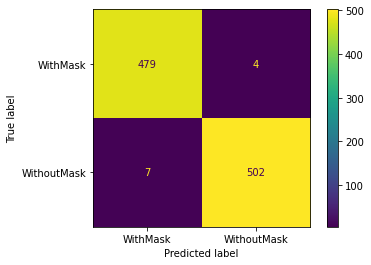

In [ ]:
#confusion matrix for test dataset
print('Confusion Matrix')
confmat = confusion_matrix(test_dataset.classes,np.array(y_pred_imp).argmax(axis=1))
disp = ConfusionMatrixDisplay(confusion_matrix=confmat, display_labels=['WithMask','WithoutMask'])
disp.plot()
plt.show()

Dari confesion matrix dapat dilihat :
- With Mask: model memprediksi 479 orang memakai masker dan memprediksi 4 data memakai masker pdahal dia tidak memakai masker
- without mask: model memprediksi 502 tidak memakai masker dan mempredisksi 7 data tidak memakai masker padahal dia memakai masker 

#9- Model Inference

Saving 52417359a95cde28fe1fcedfa01fde12.jpg to 52417359a95cde28fe1fcedfa01fde12.jpg


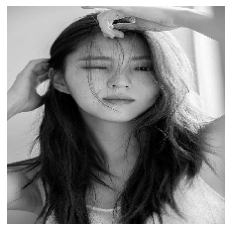

1/1 [==============================] - 0s 168ms/step
[[1. 0.]]
WithoutMask


In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = load_img(path, target_size=(220,220)) #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = img_to_array(img) # untuk ubah image kedalam array
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model_imp2.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] == 0:
    print('WithMask')
  else:
    print('WithoutMask')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#make inference data preprocesing for model input
inf_datagen = ImageDataGenerator(rescale=1/255.0)

inf_path = '/content/drive/MyDrive/Validation/'

inf_data = inf_datagen.flow_from_directory(inf_path,
                                               batch_size=64,
                                               class_mode='categorical',
                                               target_size=(220, 220),
                                               shuffle = False)

Found 10 images belonging to 2 classes.


Class :  WithMask


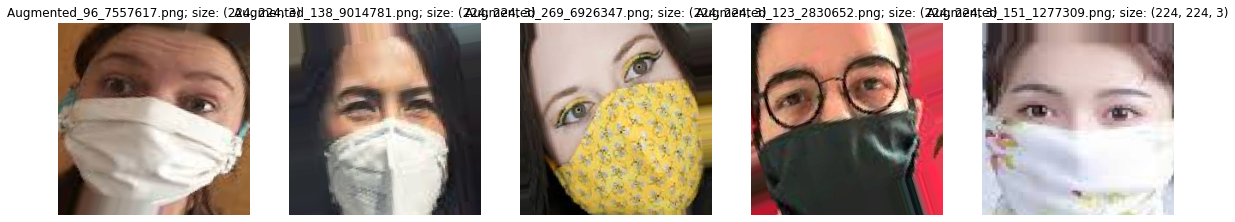

Class :  WithoutMask


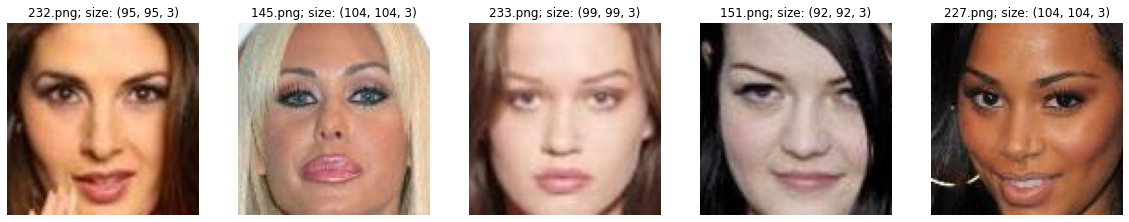

In [ ]:
#print all photo in inference dataset

target_inf_folder = '/content/drive/MyDrive/Validation/'

classes = {
    'WithMask': 'WithMask',
    'WithoutMask' : 'WithoutMask'
    
}

for i in classes.keys():
  folder_name = classes[i]
  fig = plt.figure(figsize=(20,12))
  columns = 5
  rows = 3
  print('Class : ', i)
  a = 1
  for index in os.listdir(target_inf_folder + i):
      fig.add_subplot(rows, columns, a)
      image = plt.imread(target_inf_folder + i + '/' + index)
      plt.imshow(image)
      plt.title(f'{index}; size: {image.shape}')
      plt.axis("off")
      a = a + 1
  plt.show()

- Dari 10 model yang di pelajari model berhasil memprediksi semua benar

In [ ]:
#do model prediction
y_inf_pred_imp = model_imp2.predict(inf_data)

1/1 [==============================] - 0s 306ms/step


In [ ]:
#prediction result
y_inf_pred_imp

array([[9.9994910e-01, 5.0917599e-05],
       [9.9993515e-01, 6.4855572e-05],
       [9.9994397e-01, 5.5988356e-05],
       [9.9843496e-01, 1.5649742e-03],
       [9.9994850e-01, 5.1445844e-05],
       [1.0939123e-03, 9.9890614e-01],
       [4.4017653e-03, 9.9559826e-01],
       [1.3583672e-06, 9.9999869e-01],
       [1.0185499e-05, 9.9998987e-01],
       [1.9223263e-03, 9.9807763e-01]], dtype=float32)

In [ ]:
#relabeling the prediction result with 0 = WithMask and 1 = WithoutMask
res = np.array(y_inf_pred_imp).argmax(axis=1)
res = np.where(res == 0, 'WithMask', 'WithoutMask')
res

array(['WithMask', 'WithMask', 'WithMask', 'WithMask', 'WithMask',
       'WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask',
       'WithoutMask'], dtype='<U11')

In [ ]:
#actual labels of inference data
inf_data.labels

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
#prediction result in labels
inf = np.array(y_inf_pred_imp).argmax(axis=1)

In [ ]:
data_new = inf_data.labels.tolist()
data_new

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1]

In [ ]:
import json

data = json.dumps({
    "signature_name": "serving_default",
    "instances": data_new
})

data

'{"signature_name": "serving_default", "instances": [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]}'

In [ ]:
import requests

URL = "http://backend-mask-detect.herokuapp.com/v1/models/mask_detection2:predict"
r = requests.post(URL, data)
r

<Response [400]>

#10- Saving Model

In [ ]:
# freeze model
model_imp2.trainable = False

In [ ]:
model_imp2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 218, 218, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 109, 109, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 107, 107, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 53, 53, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 179776)            0         
                                                                 
 dense_2 (Dense)             (None, 32)               

In [ ]:
# save model
model_imp2.save("mask_detection2")

In [ ]:
model_name = "/content/mask_detection_best2.h5"
tf.keras.models.save_model(model, model_name)

In [ ]:
! zip -r model_imp2.zip mask_detection2

  adding: mask_detection2/ (stored 0%)
  adding: mask_detection2/keras_metadata.pb (deflated 91%)
  adding: mask_detection2/variables/ (stored 0%)
  adding: mask_detection2/variables/variables.data-00000-of-00001 (deflated 29%)
  adding: mask_detection2/variables/variables.index (deflated 66%)
  adding: mask_detection2/saved_model.pb (deflated 89%)
  adding: mask_detection2/assets/ (stored 0%)


In [ ]:
model_json = model_imp2.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# 11-Kesimpulan

`EDA:` 
- Dari EDA dapat dilihat bahwa data sudah terbagi menjadi Train Test dan Validation dan data sudah dalam keadaan balance.
-Dari EDA diketahui jjuga terdapat 2 class yaitu with mask dan withoutmask

`Model Definition`
- Model Baseline: dilihat disini menggunakan 4 filters dan  3 kernel, dengan output layer 2 neuron, dengan ditambahkan aktivasi relu dimana untuk menyalakan neuron ,untuk aktifasi peneliti memilih Softmax dimana softmax untuk clasisifikasi  2 atau multiclass , disini peneliti untuk menerapkan baseline model memakai Softmax. Untuk loss peneliti memakai categorical_crossentropy, categorical_crossentropy adalah fungsi loss default yang digunakan untuk masalah klasifikasi dengan 2 class, , untuk baseline peneliti mencoba memakai optimizer Adam, dan untuk metrics memakai accuracy, dikarenakan ingin membuat model untuk case classification dan lakukan epoch 10
-Model Improvment: dilihat disini menggunakan 32 filters dan 3 kernel, dengan output layer 2 neuron, dengan ditambahkan aktivasi relu dimana untuk menyalakan neuron ,untuk aktifasi peneliti memilih Softmax dimana softmax untuk clasisifikasi 2 atau multiclass , disini peneliti untuk menerapkan baseline model memakai Softmax. Untuk loss memakai categorical_crossentropy, categorical_crossentropy adalah fungsi loss default yang digunakan untuk masalah klasifikasi dengan 2 class, , untuk baseline peneliti mencoba memakai optimizer Adam, dan untuk metrics memakai accuracy, dikarenakan ingin membuat model untuk case classification dan menggunkan 50 epoch
`Model Evalution`
-Model Baseline : Model berhasil melalkukan predict dengan akurasi 95% dan dilihat dari Dari confesion matrix dapat dilihat :
-- With Mask: model memprediksi 473 orang memakai masker dan memprediksi 10 data memakai masker pdahal dia tidak memakai masker
-- without mask: model memprediksi 467 tidak memakai masker dan mempredisksi 42 data tidak memakai masker padahal dia memakai masker 
-Model Improvemnt : Model berhasil melalkukan predict dengan akurasi 99% dan dilihat dari Dari confesion matrix dapat dilihat : 
-- With Mask: model memprediksi 479 orang memakai masker dan memprediksi 4 data memakai masker pdahal dia tidak memakai masker
-- without mask: model memprediksi 502 tidak memakai masker dan mempredisksi 7 data tidak memakai masker padahal dia memakai masker 

`Data preprocessing`
- Untuk preprocessing gambar, beberapa parameter yang digunakan sebagai berikut: rescale: untuk mengubah matriks warna menjadi 255. rentang rotasi: itu untuk membuat variasi untuk bentuk topeng, agar model belajar bentuknya tidak selalu dalam bentuk reactangle. Pergeseran lebar dan pergeseran tinggi: untuk memastikan bahwa foto tidak selalu di tengah foto. 
- tinggi dan lebar foto yang digunakan adalah 220 x 220 dengan seed=1 dan Batch 64
- Untuk data train, paramater shuffle dibiarkan sebagai True untuk mengacak sampel perepoch sehingga membuat model belajar lebih banyak tanpa melihat urutan sampel.

`Model Definition`
- Model Baseline: dilihat disini menggunakan 4 filters dan  3 kernel, dengan output layer 2 neuron, dengan ditambahkan aktivasi relu dimana untuk menyalakan neuron ,untuk aktifasi peneliti memilih Softmax dimana softmax untuk clasisifikasi  2 atau multiclass , disini peneliti untuk menerapkan baseline model memakai Softmax. Untuk loss peneliti memakai categorical_crossentropy, categorical_crossentropy adalah fungsi loss default yang digunakan untuk masalah klasifikasi dengan 2 class, , untuk baseline peneliti mencoba memakai optimizer Adam, dan untuk metrics memakai accuracy, dikarenakan ingin membuat model untuk case classification dan lakukan epoch 10
-Model Improvment: dilihat disini menggunakan 32 filters dan 3 kernel, dengan output layer 2 neuron, dengan ditambahkan aktivasi relu dimana untuk menyalakan neuron ,untuk aktifasi peneliti memilih Softmax dimana softmax untuk clasisifikasi 2 atau multiclass , disini peneliti untuk menerapkan baseline model memakai Softmax. Untuk loss memakai categorical_crossentropy, categorical_crossentropy adalah fungsi loss default yang digunakan untuk masalah klasifikasi dengan 2 class, , untuk baseline peneliti mencoba memakai optimizer Adam, dan untuk metrics memakai accuracy, dikarenakan ingin membuat model untuk case classification dan menggunkan 50 epoch

`Model Evalution` :

- Model Baseline : Model berhasil melalkukan predict dengan akurasi 95% dan dilihat dari Dari confesion matrix dapat dilihat :
-- With Mask: model memprediksi 473 orang memakai masker dan memprediksi 10 data memakai masker pdahal dia tidak memakai masker
-- without mask: model memprediksi 467 tidak memakai masker dan mempredisksi 42 data tidak memakai masker padahal dia memakai masker 
- Model Improvemnt : Model berhasil melalkukan predict dengan akurasi 99% dan dilihat dari Dari confesion matrix dapat dilihat : 
-- With Mask: model memprediksi 479 orang memakai masker dan memprediksi 4 data memakai masker pdahal dia tidak memakai masker
-- without mask: model memprediksi 502 tidak memakai masker dan mempredisksi 7 data tidak memakai masker padahal dia memakai masker 

`Model Inference`:
- Dari 11 gambar infrence model berhasil memprediksi dengan semua benar dan model memilki akurasi 100%
- untung pengembangan lebih lajut model harus lebih banyak belajar tentang gamabr lagi seperti gambar dengan orang full janggut dan kumis
- model yang kita memilki adalah Good Fit